The purpose of this notebook is to conduct topic analyses of a) the entire policy document data base and b) the policy documents of individual countries, and to compare the results between the two methods. Specifically, we are interested in seeing whether the topics of the policies we are analysing differ substantially between countries, and if a "global" topic model for all countries we are going to analyse will fit the topics of individual countries sufficiently well.

Building upon this analysis, we will:
- predict topics that ministries twitter about based on the policy topic model from the same (/all) countries
- Based on this tweet classification, analyse reactions to tweets from government ministries (by topic) - who are the actors that are engaging with these tweets, do replies tend to be positive/negative, confirmative/dissenting?
- Potential follow-up: Who are the actors that share the contents of the government tweets to the wider public?

In [ ]:
# mount google drive to prepare reading in data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change to data directory
%cd drive/MyDrive/'Colab Notebooks'/Hack4Good/data

/content/drive/MyDrive/Colab Notebooks/Hack4Good/data


In [ ]:
FIGURE_DIR = 'figures'
DATA_DIR = 'data'

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from gensim import models
from gensim.corpora import Dictionary
from wordcloud import WordCloud

In [ ]:
# read in policy docs
data = pd.read_csv("policy_texts.csv").drop(['Unnamed: 0'], axis=1)

In [ ]:
# visualise data we are dealing with
data.head()

country  year       period   doc_id  \
0  Austria  2020  intra-covid   AT_AC1   
1  Austria  2021  intra-covid  AT_B1C1   
2  Austria  2020  intra-covid  AT_B1C2   
3  Austria  2016    pre-covid  AT_B1P1   
4  Austria  2020  intra-covid  AT_B2C1   

                                               title  \
0                                FTI-Strategie 2030    
1  Österreichischer Aufbau- und Resilienzplan 202...   
2                     Digitaler Aktionsplan Austria    
3           Open Innovation Strategie für Österreich   
4                           FTI-Strategie Mobilität    

                                       text_original  \
0    FTI-Strategie 2030 Strategie der Bundesregie...   
1        Österreichischer Aufbau- und Resilienzpl...   
2                                         Digital...   
3    Open Innovation Strategy for Austria        ...   
4           FTI-Strategie Mobilität Innovationen ...   

                                     text_translated  \
0  "x" "1" "FTI - Strategy 2030   Federal governm...   
1  "x" "1" "Austrian development and resilience p...   
2  "x" "1" "More digital   Action plan Austria   ...   
3  "x" "1" "Open   Innovation   Strategy   for   ...   
4  "x" "1" "RTI - Mobility Strategy   Innovations...   

                                          text_clean  
0  government_strategy research technology innova...  
1  development resilience_plan content objective ...  
2  digital plan content future crisis-proof innov...  
3  great strength country innovative capability p...  
4  climate-neutral mobility_system imprint owner ...

In [ ]:
# in our analysis, we want to focus on policies from 2019-2022:
years = [2019, 2020, 2021, 2022]

filtered_data = data.loc[data.year.isin(years)]
filtered_data = filtered_data.reset_index()

In [ ]:
# utils: functions to be used for these analysis steps

# function to run topic modelling for selected policy documents:
def topic_modelling(policy_df: pd.DataFrame, countries: list, nb_topics: int, passes: int, level='paragraph') -> (pd.DataFrame, models.LdaModel):
    # extract relevant policies from overall df:
    policies_tm = policy_df.where(policy_df.country.isin(countries)).dropna()

    # convert into gensim corpus format to fit the topic modelling
    if level == 'text_clean':
        documents = list(policies_tm.text_clean.apply(lambda x: x.split(" ")))
    elif level == 'paragraph':
        documents = list(policies_tm.paragraph)
    elif level == 'tweet':
        documents = list(policies_tm.nouns_adjs)
    else:
        print('error. need to specify a valid level for the analysis.')
    dictionary = Dictionary(documents)
    corpus = [dictionary.doc2bow(text) for text in documents]

    # idea for topic modelling: choose number of topics on fairly small number of passes (~10)
    # once topics seem to make sense: increase number of passes (--> ~100)
    print('starting fitting topic model...')
    start_time_tm = time.time()
    lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=nb_topics, passes=passes, random_state=0) # use random state for reproducibility
    print('finished fitting topic model in %d minutes and %d seconds'%((time.time()-start_time_tm)//60, (time.time()-start_time_tm)%60))

    return policies_tm, dictionary, lda

# function to split data into paragraphs: for better topic model fits
def get_paragraph_data(df, words_per_paragraph=50):
	# create a new df with documents split up into "paragraphs" of up to 50 words each

    paragraph_array = []
    doc_ids = []
    for i in range(df.shape[0]):
        all_words = df.loc[i, 'text_clean'].split(" ")
        while all_words:
            this_paragraph = all_words[:np.min((words_per_paragraph, len(all_words)))]
            paragraph_array.append(this_paragraph)
            doc_ids.append(data.loc[i, 'doc_id'])
            all_words = all_words[np.min((words_per_paragraph, len(all_words))):]
    paragraph_data = pd.DataFrame({'doc_id': doc_ids, 'paragraph': paragraph_array})
    return paragraph_data

def predict_topics(predict_text, lda_model):
    # convert text into bag-of-word format for topic prediciton with gensim
    predict_text = [x for doc in predict_docs for x in doc]
    bow = dict_list[0].doc2bow(predict_text)
    return lda_model[bow]

def generate_word_clouds(df: pd.DataFrame, topic_col: str, word_col: str, nb_topics: int, fig_dir: str):
	
    wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

    # continue adjusting this code on Monday
    # make sure it works for both the policy document topic model and the layer-2 green-energy one

    for topic in range(nb_topics):
        words_this_topic = df.where(df[topic_col]==topic).dropna().loc[:,word_col]
        filtered_words = [item for subl in words_this_topic for item in subl if item not in ['new', 'amp']] # filter out noise in within green energy model, no impact on other one
        words_this_topic = " ".join(filtered_words)
        wc.generate(words_this_topic)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.savefig(fig_dir + '/' + topic_col + '_wordcloud_topic_' + str(topic) + '.png')


In [ ]:
# subselect list of countries for analysis
selected_countries = ["Costa Rica", "Finland", "France", "Italy", "Japan", "Sweden", "United States"]

# for training: use all countries to get the best possible topic model for a range of policy topics
all_countries = data.country.unique()

# get pargraph data for better fits of the topic model:
paragraph_data = get_paragraph_data(filtered_data)
paragraph_data = filtered_data.merge(paragraph_data, on='doc_id') # merge paragraphs with previous df
paragraph_data.head()

index  country  year       period  doc_id                title  \
0      0  Austria  2020  intra-covid  AT_AC1  FTI-Strategie 2030    
1      0  Austria  2020  intra-covid  AT_AC1  FTI-Strategie 2030    
2      0  Austria  2020  intra-covid  AT_AC1  FTI-Strategie 2030    
3      0  Austria  2020  intra-covid  AT_AC1  FTI-Strategie 2030    
4      0  Austria  2020  intra-covid  AT_AC1  FTI-Strategie 2030    

                                       text_original  \
0    FTI-Strategie 2030 Strategie der Bundesregie...   
1    FTI-Strategie 2030 Strategie der Bundesregie...   
2    FTI-Strategie 2030 Strategie der Bundesregie...   
3    FTI-Strategie 2030 Strategie der Bundesregie...   
4    FTI-Strategie 2030 Strategie der Bundesregie...   

                                     text_translated  \
0  "x" "1" "FTI - Strategy 2030   Federal governm...   
1  "x" "1" "FTI - Strategy 2030   Federal governm...   
2  "x" "1" "FTI - Strategy 2030   Federal governm...   
3  "x" "1" "FTI - Strategy 2030   Federal governm...   
4  "x" "1" "FTI - Strategy 2030   Federal governm...   

                                          text_clean  \
0  government_strategy research technology innova...   
1  government_strategy research technology innova...   
2  government_strategy research technology innova...   
3  government_strategy research technology innova...   
4  government_strategy research technology innova...   

                                           paragraph  
0  [government_strategy, research, technology, in...  
1  [future, possibility, joint, introduction, loc...  
2  [total, research_unit, leading, international_...  
3  [characteristic, established, research_landsca...  
4  [research, premium, retained, location, strate...

In [ ]:
# step 1: "global" topic modelling for all countries combined

# for exploratory analysis, can vary the number of topics and compare results (10 seemed a good fit)
# if experimenting with different number of topics: set PASSES to ~20 to reduce the runtime of LDA model fitting
nb_topics = [8]
PASSES = 50

# we need the LDA models and corresponding dictionaries for interpretation and topic prediction
lda_list, dict_list = [], []
for nb_ in nb_topics:
    policy_df, dct, lda = topic_modelling(paragraph_data, all_countries, nb_, PASSES) # fit on ALL countries, then sub-select later
    lda_list.append(lda)
    dict_list.append(dct)

starting fitting topic model...
finished fitting topic model in 13 minutes and 26 seconds


In [ ]:
lda_list[0].print_topics() # for first LDA fitted with #topics = nb_topics[0]

[(0,
  '0.017*"covid" + 0.013*"health" + 0.012*"appropriated" + 0.012*"support" + 0.011*"service" + 0.010*"people" + 0.009*"programme" + 0.008*"community" + 0.007*"care" + 0.007*"disease"'),
 (1,
  '0.013*"increase" + 0.010*"education" + 0.010*"measure" + 0.010*"employment" + 0.009*"student" + 0.008*"gdp" + 0.006*"women" + 0.006*"labour_market" + 0.006*"school" + 0.006*"average"'),
 (2,
  '0.018*"research" + 0.014*"development" + 0.013*"support" + 0.010*"programme" + 0.009*"innovation" + 0.007*"university" + 0.007*"company" + 0.007*"project" + 0.007*"government" + 0.006*"business"'),
 (3,
  '0.049*"section" + 0.024*"amount" + 0.018*"subsection" + 0.013*"paragraph" + 0.012*"made" + 0.011*"term" + 0.010*"fund" + 0.009*"period" + 0.009*"title" + 0.008*"payment"'),
 (4,
  '0.013*"energy" + 0.009*"emission" + 0.008*"hydrogen" + 0.008*"increase" + 0.007*"co2" + 0.007*"addition" + 0.007*"supply" + 0.006*"market" + 0.006*"production" + 0.006*"base"'),
 (5,
  '0.027*"ai" + 0.015*"technology" + 

In [ ]:
# predict topics for selected countries:
predicted_topics = dict()
for country in selected_countries:
    # subselect country data and convert into bag-of-word format for topic prediciton with gensim
    df_this_country = data.where(data.country==country).dropna()
    predict_docs = df_this_country.text_clean.apply(lambda x: x.split(" "))
    predict_text = [x for doc in predict_docs for x in doc]
    predicted_topics[country] = predict_topics(predict_text, lda_list[0])

In [ ]:
# convert data to dict for plotting
country_list, topic_list, score_list = [[] for _ in range(3)]
for country in selected_countries:
    for topic in predicted_topics[country]:
        topic_list.append(topic[0])
        score_list.append(topic[1])
        country_list.append(country)

# plot topics per country
plot_df = pd.DataFrame({'country': country_list, 'topic': topic_list, 'score': score_list})
fig, ax = plt.subplots(1,1,figsize=(13,8))
sns.barplot(data=plot_df, x='topic', y='score', hue='country', ax=ax)#, s=100)

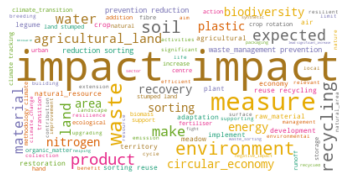

In [ ]:
# WORDCLOUD PLOT, TOPIC MODEL FOR ALL TWEETS:

examples = [dict() for _ in range(8)]

for i in range(paragraph_data.shape[0]):
    current_paragraph = paragraph_data.loc[i, 'paragraph']
    bow = dict_list[0].doc2bow(current_paragraph)
    topics_current_paragraph = lda_list[0][bow]
    for topic, score in topics_current_paragraph:
        if score > 0.8:
            if 'score' not in examples[topic].keys():
                examples[topic]['score'] = []
                examples[topic]['text'] = []
            examples[topic]['score'].append(score)
            examples[topic]['text'].append(current_paragraph)

topic_array = [[i] * len(examples[i]['score']) for i in range(8)]
topic_array = [item for subl in topic_array for item in subl]
score_array = [examples[i]['score'] for i in range(8)]
score_array = [item for subl in score_array for item in subl]
text_array = [examples[i]['text'] for i in range(8)]
text_array = [item for subl in text_array for item in subl]

examples_df = pd.DataFrame({'topic': topic_array, 'score': score_array, 'text': text_array})
generate_word_clouds(df=examples_df, topic_col='topic', word_col='text', nb_topics=len(np.unique(examples_df.topic))-1, fig_dir= FIGURE_DIR)

In [ ]:
# predict tweet topic using the policy document topic model:
csv_files = ['Costa_trans.csv', 'France_trans.csv', 'Germany_trans.csv', "USA_trans.csv", "Japan_trans.csv", "Italy_trans.csv",
             "Finland1_trans.csv", "Finland2_trans.csv"]

for count, file in enumerate(csv_files):
    tweets_one_country = pd.read_csv("ministry_tweets/" + file)
    if count == 0:
        tweets_all_countries = tweets_one_country
    else:
        print(csv_files[count])
        tweets_all_countries = pd.concat([tweets_all_countries,tweets_one_country], ignore_index = True)

France_trans.csv
Germany_trans.csv
USA_trans.csv
Japan_trans.csv
Italy_trans.csv
Finland1_trans.csv
Finland2_trans.csv


In [ ]:
# drop column with too many nas and some irrelevant ministries
# make sure not too many na values dropped here
ministries_to_exclude = ["National Aeronautics and Space Administration", "Department of Veteran Affairs"]

tweets = tweets_all_countries.drop(["Label"], axis=1).dropna() # many nans in original label
tweets = tweets.where(~tweets.EnglishLabel.isin(ministries_to_exclude)).dropna()


# assign topics to government ministry tweets using the topic model trained on policy documents
THRESHOLD = 0.5

text_split = tweets.text_en.apply(lambda x: x.split(" "))
predicted_topics = text_split.apply(lambda x: lda_list[0][dict_list[0].doc2bow(x)])

assigned_topics = []
for row in predicted_topics:
    current_topic =  -1
    for topic, score in row:
        if score > THRESHOLD:
            current_topic = topic
    assigned_topics.append(current_topic)
tweets['topic'] = assigned_topics

# convert into a df with columns country, ministry, and one for each of the topic, containing counts for each combination as cell values
country_array, ministry_array = [], []
topic_arrays = [[] for _ in range(9)] # 8 topics and "undefined"
topic_df = tweets.groupby(["Country", "EnglishLabel"]).topic.value_counts()
for country in topic_df.index.get_level_values(0).unique():
    for ministry in topic_df.loc[country].dropna().index.get_level_values(0).unique():
        country_array.append(country)
        ministry_array.append(ministry)
        for topic in range(-1, 8):
            try:
                topic_arrays[topic+1].append(topic_df.loc[country, ministry, topic])
            except:
                topic_arrays[topic+1].append(0)
                pass # not all countries have tweets related to all topics

tweet_topic_df = pd.DataFrame({'country': country_array, 'ministry': ministry_array})
for topic in range(-1, 8):
    name = 't' + str(topic)
    tweet_topic_df[name] = topic_arrays[topic+1]

tweet_topic_df.head()

country                                           ministry   t-1   t0   t1  \
0     CRI                          Distance State University   360   94   77   
1     CRI                            Export Promotion Agency   418   22   55   
2     CRI         Ministry of Economy, Industry and Commerce  1147  212  200   
3     CRI                 Ministry of Environment and Energy   886   76   62   
4     CRI  Ministry of Science, Innovation, Technology an...  1366  468  114   

    t2   t3  t4   t5   t6   t7  
0  120   25   7   50    6  116  
1  240    7  46  225   35   31  
2  615  106  65  240   40  243  
3  177   23  72  118  153  169  
4  843  114  39  281   54  397

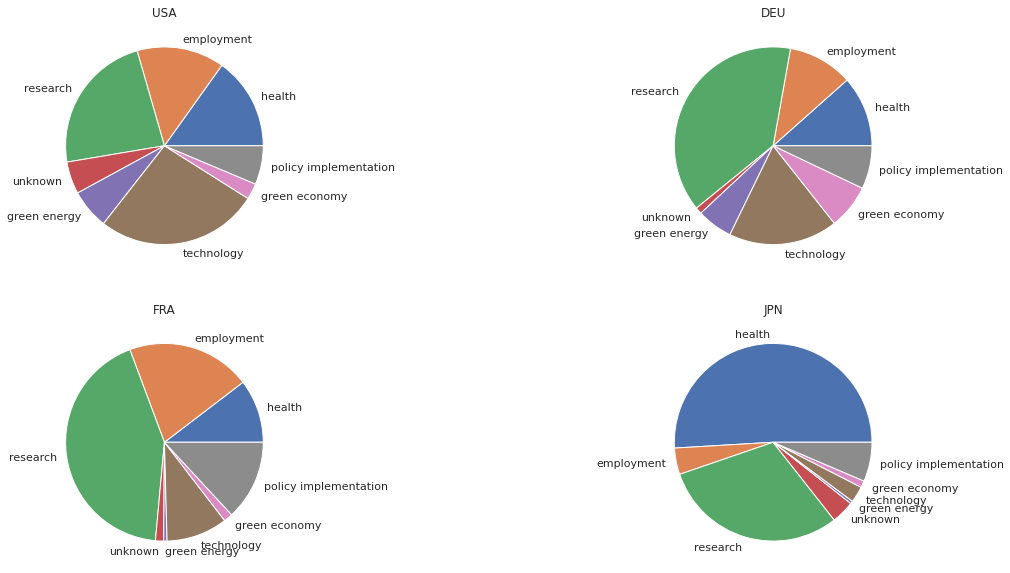

In [ ]:
# overview plot: which topics do US ministries tweet about?

# FOR COUNTRIES
# Pie chart:
sns.set(font_scale=1)
fig, axs = plt.subplots(2, 2, figsize=(20,10))
selected_countries = ['USA', "DEU", "FRA", "JPN"]
# selected_ministries = ['Department of Energy', 'National Institutes of Health',
                    #    'National Science Foundation', 'Office of Science and Technology Policy', 'The White House']

sub_df = tweet_topic_df.loc[(tweet_topic_df.country.isin(selected_countries))]

for count, country in enumerate(selected_countries):
    row_idx = count // 2
    col_idx = count % 2
    data = sub_df.loc[sub_df.country==country,['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7']].values[0]
    # labels = ['topic' + str(i) for i in range(8)]
    labels = ['health', 'employment', 'research', 'unknown', 'green energy', 'technology', 'green economy', 'policy implementation']
    axs[row_idx][col_idx].pie(x=data, labels=labels)
    axs[row_idx][col_idx].set_title(country)

In [ ]:
# overview plot: which topics do US ministries tweet about?

# Pie chart:
sns.set(font_scale=1)
fig, axs = plt.subplots(2, 3, figsize=(20,10))
country = "USA"
selected_ministries = ['Department of Energy', 'National Institutes of Health',
                       'National Science Foundation', 'Office of Science and Technology Policy', 'The White House', 'Office of Management and Budget']

sub_df_USA = tweet_topic_df.loc[(tweet_topic_df.country==country) & (tweet_topic_df.ministry.isin(selected_ministries))]

for count, min in enumerate(selected_ministries):
    row_idx = count // 3
    col_idx = count % 3
    data = sub_df_USA.loc[sub_df_USA.ministry==min,['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7']].values[0]
    # labels = ['topic' + str(i) for i in range(8)]
    labels = ['health', 'employment', 'research', 'unknown', 'green energy', 'technology', 'green economy', 'policy implementation']
    axs[row_idx][col_idx].pie(x=data, labels=labels)
    axs[row_idx][col_idx].set_title(min)

In [ ]:
# save data frame for sub-topic modeling analysis focusing on green energy

tweet_topic_df.to_csv(DATA_DIR + '/tweet_topic_df.csv')

In [ ]:
# check distribution of topics for all ministries: 
# tweets.topic.value_counts()

# for selected ministries:
# tweets.where(tweets.EnglishLabel=='Federal Ministry of Education and Research').dropna().topic.value_counts()

# SAVE GREEN ENERGY RELATED TWEETS IN SEPARATE DF:
all_countries_ge_tweets = tweets.where(tweets.topic==4).dropna()
all_countries_ge_tweets.to_csv(DATA_DIR + "/all_countries_ge_tweets.csv")